In [2]:
#inverse probability weighting
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.stats import ttest_ind
from statsmodels.stats.weightstats import CompareMeans

In [5]:
import os
print(os.getcwd())


C:\Users\Rohini\sml_project


In [3]:
df = pd.read_csv(r'C:\Users\Rohini\sml_project\datasets\ihdata.csv')
df

,treatment,outcome_factual,outcome_counterfactual,mu0,mu1,income,birth_weight,parent_edu,health_index,housing_quality,...,x20,x21,x22,x23,x24,x25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29
0,1,5.599916,4.318780,3.268256,6.854457,-0.528603,-0.343455,1.128554,0.161703,-0.316603,...,1,1,1,1,0,0,0,0,0,0
1,0,6.875856,7.856495,6.636059,7.562718,-1.736945,-1.802002,0.383828,2.244320,-0.629189,...,1,1,1,1,0,0,0,0,0,0
2,0,2.996273,6.633952,1.570536,6.121617,-0.807451,-0.202946,-0.360898,-0.879606,0.808706,...,1,0,1,1,0,0,0,0,0,0
3,0,1.366206,5.697239,1.244738,5.889125,0.390083,0.596582,-1.850350,-0.879606,-0.004017,...,1,0,1,1,0,0,0,0,0,0
4,0,1.963538,6.202582,1.685048,6.191994,-1.045229,-0.602710,0.011465,0.161703,0.683672,...,1,1,1,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
742,0,4.091946,6.061976,3.986826,7.053195,-0.007654,-0.202946,-0.360898,0.161703,-0.316603,...,1,0,1,0,0,0,0,0,0,0
743,1,5.501677,4.237157,4.111877,7.084080,0.727295,-0.202946,-0.733261,-0.879606,0.808706,...,1,1,1,0,0,0,0,0,0,0
744,0,1.842583,4.949537,2.346736,6.523225,1.181234,0.196818,-1.477987,0.161703,0.746189,...,1,1,1,0,0,0,0,0,0,0
745,0,3.076368,7.554212,2.114661,6.419095,-0.288664,-0.202946,-1.477987,-0.879606,1.621430,...,1,1,1,0,0,0,0,0,0,0


In [21]:
df.head()

,treatment,outcome_factual,outcome_counterfactual,mu0,mu1,income,birth_weight,parent_edu,health_index,housing_quality,...,x23,x24,x25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,propensity_score,weight,outcome_pred
0,1,5.599916,4.318780,3.268256,6.854457,-0.528603,-0.343455,1.128554,0.161703,-0.316603,...,1,0,0,0,0,0,0,0.283505,3.527272,4.437298
1,0,6.875856,7.856495,6.636059,7.562718,-1.736945,-1.802002,0.383828,2.244320,-0.629189,...,1,0,0,0,0,0,0,0.068051,1.073020,5.368523
2,0,2.996273,6.633952,1.570536,6.121617,-0.807451,-0.202946,-0.360898,-0.879606,0.808706,...,1,0,0,0,0,0,0,0.107717,1.120720,2.313156
3,0,1.366206,5.697239,1.244738,5.889125,0.390083,0.596582,-1.850350,-0.879606,-0.004017,...,1,0,0,0,0,0,0,0.129523,1.148795,1.877158
4,0,1.963538,6.202582,1.685048,6.191994,-1.045229,-0.602710,0.011465,0.161703,0.683672,...,1,0,0,0,0,0,0,0.092541,1.101979,2.227888


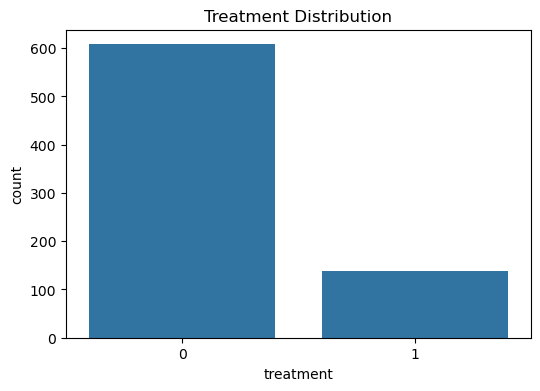

In [4]:
plt.figure(figsize=(6,4))
sns.countplot(x='treatment', data=df)
plt.title("Treatment Distribution")
plt.show()

In [13]:
# Step 2: Propensity Score Estimation
X = df.drop(columns=['treatment', 'outcome_factual', 'outcome_counterfactual', 'mu0', 'mu1'])
y = df['treatment'].astype(int)

propensity_model = LogisticRegression()
propensity_model.fit(X, y)
df['propensity_score'] = propensity_model.predict_proba(X)[:,1]

In [14]:
# Step 3: Inverse Probability Weighting (IPW)
df['weight'] = np.where(df['treatment'] == 1, 1/df['propensity_score'], 1/(1-df['propensity_score']))

In [15]:
# Step 4: Estimating Treatment Effects
ate = np.mean(df[df['treatment']==1]['outcome_factual']) - np.mean(df[df['treatment']==0]['outcome_factual'])
print(f"Average Treatment Effect (ATE): {ate:.4f}")

Average Treatment Effect (ATE): 4.0211


In [16]:
# Step 5: Causal Effect Estimation using ML
X_train, X_test, y_train, y_test = train_test_split(X, df['outcome_factual'], test_size=0.2, random_state=42)
model = RandomForestRegressor()
model.fit(X_train, y_train)
preds = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print(f"Model RMSE: {rmse:.4f}")

Model RMSE: 1.8110


In [17]:
# Step 6: Hypothesis Testing
t_stat, p_value = ttest_ind(df[df['treatment'] == 1]['outcome_factual'], df[df['treatment'] == 0]['outcome_factual'])
print(f"T-Test p-value: {p_value:.4f}")
     

T-Test p-value: 0.0000


In [18]:
# Step 7: Effect Size Calculation (Cohen's d)
mean_treated = np.mean(df[df['treatment'] == 1]['outcome_factual'])
mean_control = np.mean(df[df['treatment'] == 0]['outcome_factual'])
std_pooled = np.sqrt((np.var(df[df['treatment'] == 1]['outcome_factual']) + np.var(df[df['treatment'] == 0]['outcome_factual'])) / 2)
cohens_d = (mean_treated - mean_control) / std_pooled
print(f"Effect Size (Cohen's d): {cohens_d:.4f}")

Effect Size (Cohen's d): 2.9312


In [19]:
# Step 8: Bootstrapped Confidence Intervals for ATE
def bootstrap_ci(data, n_bootstrap=1000, ci=95):
    boot_ate = []
    for _ in range(n_bootstrap):
        sample = data.sample(frac=1, replace=True)
        boot_ate.append(np.mean(sample[sample['treatment']==1]['outcome_factual']) - np.mean(sample[sample['treatment']==0]['outcome_factual']))
    lower = np.percentile(boot_ate, (100 - ci) / 2)
    upper = np.percentile(boot_ate, 100 - (100 - ci) / 2)
    return lower, upper

ci_lower, ci_upper = bootstrap_ci(df)
print(f"Bootstrapped 95% Confidence Interval for ATE: ({ci_lower:.4f}, {ci_upper:.4f})")

Bootstrapped 95% Confidence Interval for ATE: (3.7984, 4.2373)


In [22]:
# Step 9: Doubly Robust Estimator using Regression Adjustment
from sklearn.linear_model import LinearRegression

reg_model = LinearRegression()
reg_model.fit(X, df['outcome_factual'])
df['outcome_pred'] = reg_model.predict(X)
dre_ate = np.mean(df[df['treatment'] == 1]['outcome_pred']) - np.mean(df[df['treatment'] == 0]['outcome_pred'])
print(f"Doubly Robust Estimated ATE: {dre_ate:.4f}")

Doubly Robust Estimated ATE: 0.5314
